# CTR Prediction with Stochastic Gradient Descent
In this assignment, you will work on implementing a widely used solution for click-through rate prediction problem. 

Click-through rate prediction problem is a computational problem considered at many search engine and e-commerce companies. The goal is to decide which ad to display along with the search results (e.g. web pages, videos, products). Many ads are sold on pay-per-click basis and the company only pays for ad clicks, not ad views. As a research scientist or a research engineer, your goal is to implement and deploy an algorithmic solution that predicts whether an ad will be clicked.

Throughout the notebook you'll see TODO tags in the comments. This is where you should insert your own code to make the functions work! If you get stuck, we encourage you to come to office hours. You can also try to look at APIs and documentation online to try to get a sense how certain methods work. If you take inspiration from any source online other than official documentation, please be sure to cite the resource! Good luck!

First we will start with mandatory imports.

In [65]:
# Mandatory imports.
from matplotlib import colors
import matplotlib.pyplot as plt
import math
import numpy
import scipy
from scipy.optimize import minimize
from numpy.lib import recfunctions as rfn
from sklearn.preprocessing import OneHotEncoder

# Preprocessing (5 points)
In this section, we will load a sample of Criteo data and preprocess categorical features into one-hot-encoding.

In [66]:
# Load the training data and check features.
labeled_data = numpy.genfromtxt('train_subsampled', dtype=float, delimiter=',', names=True) 
print(len(labeled_data), ' training points found with the features: ')
print(labeled_data.dtype)
print('A total of ', len(labeled_data.dtype), ' features.')

20000  training points found with the features: 
[('id', '<f8'), ('click', '<f8'), ('hour', '<f8'), ('C1', '<f8'), ('banner_pos', '<f8'), ('site_id', '<f8'), ('site_domain', '<f8'), ('site_category', '<f8'), ('app_id', '<f8'), ('app_domain', '<f8'), ('app_category', '<f8'), ('device_id', '<f8'), ('device_ip', '<f8'), ('device_model', '<f8'), ('device_type', '<f8'), ('device_conn_type', '<f8'), ('C14', '<f8'), ('C15', '<f8'), ('C16', '<f8'), ('C17', '<f8'), ('C18', '<f8'), ('C19', '<f8'), ('C20', '<f8'), ('C21', '<f8')]
A total of  24  features.


In [67]:
# These are the features we will use for classification so subselect fields.
features_to_use = ['click', 'C1', 'device_type', 'C15', 'C16']
labeled_data = labeled_data[features_to_use]
print(len(labeled_data), ' training points found with the features: ')
print(labeled_data.dtype)
print('A total of ', len(labeled_data.dtype), ' features.')

# Convert the labeled data into unstructured array.
labeled_data = rfn.structured_to_unstructured(labeled_data)
labeled_data_X = labeled_data[:, 1:]
labeled_data_Y = labeled_data[:, 0]

# Since the Y's in the Criteo data is {0, 1}, need to convert to use {-1, 1}.
for i in range(labeled_data_Y.shape[0]):
    labeled_data_Y[i] = 1 if labeled_data_Y[i] > 0 else -1

20000  training points found with the features: 
{'names':['click','C1','device_type','C15','C16'], 'formats':['<f8','<f8','<f8','<f8','<f8'], 'offsets':[8,24,112,136,144], 'itemsize':192}
A total of  5  features.


In [85]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split

# TODO: Converts an unstructued numpy 2-D array consisting of categorical values into a numpy 2-D array
# consisting of one-hot-encoded vectors.
#
# You may find OneHotEncoder in sklearn useful.
def preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y):
    
    # Apply one-hot-encoding.
    # creating one hot encoder object with categorical feature 0 
    # indicating the first column 
    onehotencoder = OneHotEncoder() 
    labeled_data_X = onehotencoder.fit_transform(labeled_data_X).toarray()
   
    # Divide the data into train/validation.
    training_data_X, validation_data_X, training_data_Y, validation_data_Y = \
    train_test_split(labeled_data_X, labeled_data_Y, test_size=0.2, random_state=0)
        
    return training_data_X, training_data_Y, validation_data_X, validation_data_Y

training_data_X, training_data_Y, validation_data_X, validation_data_Y = \
    preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y)

/Users/mengjialyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


We will also load a small dataset (from homework 3) for sanity checks.

In [86]:
# Load the small data.
small_data = numpy.genfromtxt('logistic_regression.csv', dtype=float, delimiter=',', names=True)
small_data = rfn.structured_to_unstructured(small_data)
print('Loaded a small data for sanity check: ', small_data.shape)
small_data_X = small_data[:, 0:2]
small_data_Y = small_data[:, 2]

Loaded a small data for sanity check:  (200, 3)


# Classifier Class
Here is a generic classifier class with some useful functions. As we define more classifiers, we will inherit from this base class and implement supplementary methods. Please take a moment and read through the code to understand the logic. **You do not need to modify this class**.

In [87]:
# Generic classifier class.
class classifier:
    
    # Takes the number of features as an input and initializes the classifier.
    def __init__(self, num_dimensions):
        
        # Each classifier stores a weight vector whose size is equal to the number of features.
        self.weight_ = numpy.zeros( (num_dimensions,) )

    # Sets the mini batch size used for the classifier.
    def set_mini_batch_size(self, mini_batch_size_in):
        self.mini_batch_size_ = mini_batch_size_in
    
    # Initializes the history vectors.
    def init_history(self, num_epochs):
        self.obj_val_history_ = numpy.zeros( (num_epochs + 1, ))
        self.l2_norm_gradient_history_ = numpy.zeros(( num_epochs + 1, ))
        self.training_unregularized_loss_history_ = numpy.zeros( (num_epochs + 1, ) )
        self.validation_unregularized_loss_history_ = numpy.zeros( (num_epochs + 1, ) )
    
    # Takes a 2-D numpy array in which each row is a point and returns a numpy 1-D array consisting of
    # classification results (-1 or 1).
    def batch_classify(self, x_mat):
        return numpy.array([ self.classify(x_vec) for x_vec in x_mat])
       
    # Takes the learning rate, weight gradient and performs one update to the weight vector. Please lecture notes
    # for more details.
    def update_weight(self, learning_rate, weight_gradient):
        self.weight_ = self.weight_ - learning_rate * weight_gradient
    
    # Stores history of optimization progress.
    def add_to_history(self, obj_val, weight_gradient, epoch_num, X, Y, validation_data_X, validation_data_Y ):
    
        self.obj_val_history_[epoch_num] = obj_val
        self.l2_norm_gradient_history_[epoch_num] = numpy.linalg.norm(weight_gradient, 2)
        self.training_unregularized_loss_history_[epoch_num] = self.compute_unregularized_loss(X, Y)

        if validation_data_X is not None:
            self.validation_unregularized_loss_history_[epoch_num] = \
                self.compute_unregularized_loss(validation_data_X, validation_data_Y)

# Plotting Utility
This may be useful in debugging using the small dataset used in homework 3; use this function only for two dimensional datasets. **Again, no need to modify the code here**.

In [88]:
# Plots the data with the decision boundary.
def plot_data(classifier, X, Y):
    weight = classifier.weight_
    y_pred = [classifier.classify(x) for x in X]
    tp = (Y == y_pred)  # Correctly classified
    tp0, tp1 = tp[Y == -1], tp[Y == 1]
    X0, X1 = X[Y == -1], X[Y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-20, 20)
    y_min, y_max = (-20, 20)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    xx, yy = numpy.meshgrid(
        numpy.linspace(x_min, x_max, nx),
        numpy.linspace(y_min, y_max, ny))
    
    xgrid = numpy.arange(-20, 20, 0.1)
    ygrid = [ - weight[0] / weight[1] * x_val for x_val in xgrid ]
    plt.plot(xgrid, ygrid, '--')

    # Show plots.
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

# Regularized Logistic Regression Classifier (5 points)
In this section, you will extend the base **classifier** class to implement the **logistic_regression_classifier** class. Recall from our lecture: the regularized logistic regression is the solution to the following optimization problem,
$$\arg \min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{logistic}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the logistic loss is defined by:
$$\begin{align*}
\ell_{\mathsf{logistic}}(y, \mathbf{w}^T \mathbf{x}) = \ln \left ( 1 + \exp(- y \cdot \mathbf{w}^T \mathbf{x} ) \right )
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, implement the **obj_gradient_function** which computes the regularized objective value and its gradient using a subset of training points whose indices are in **mini_batch_indices** variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regulariezd objective function at the current parameter $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

What is $\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$?

$$\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)}) =  -\frac{y^{(i_j)} \cdot \mathbf{x}^{(i_j)}\exp(- y^{(i_j)} \cdot \mathbf{w}^T \mathbf{x}^{(i_j)})}{ 1 + \exp(- y^{(i_j)} \cdot \mathbf{w}^T \mathbf{x}^{(i_j)})}$$

In [89]:
class logistic_regression_classifier(classifier):

    def __init__(self, num_dimensions):
        super(logistic_regression_classifier, self).__init__(num_dimensions)
        
    # TODO: Takes a vector and outputs 1, -1 based on the classifier.
    def classify(self, x_vec):
        dot_product = numpy.dot(x_vec, self.weight_)
        if (dot_product <= -1):
            return -1
        elif (dot_product >= 1):
            return 1
        return 0

    # Takes a 2-D numpy array X and 1-D numpy array Y and returns the unregularized average loss.
    def compute_unregularized_loss(self, x_mat, y_vec):
        return numpy.mean([ numpy.log(1 + numpy.exp(-y_vec[i] * numpy.dot(self.weight_, x_vec))) for i, x_vec in enumerate(x_mat) ])
            
    # TODO: 
    #
    # weight: the weight vector
    # X: the data matrix
    # Y: the y vector
    # mini_batch_indices: the subsample rows to choose in the X, Y pair.
    # regularization: the $\lambda$ parameter.
    # compute_obj_val: whether the function returns the objective value.
    # compute_gradient: whether the function returns the gradient.
    @staticmethod
    def obj_gradient_function(
        weight, X, Y, mini_batch_indices, regularization, compute_obj_val=True, compute_gradient=True):
        
        obj_val = 0.0
        weight_gradient = numpy.zeros((X.shape[1],))
        counter = 0
        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):
         
            # You probably need to do something here...
            numerator = -y_label*x_vec*numpy.exp(-y_label * numpy.dot(weight.T, x_vec))
            denominator = 1 + numpy.exp(-y_label * numpy.dot(weight.T, x_vec))
            weight_gradient += numerator/denominator  
            obj_val +=  numpy.log(1 + numpy.exp(-y_label * numpy.dot(weight.T, x_vec)))
            counter += 1
        # regularized
        obj_val = obj_val/counter + regularization * numpy.dot(weight.T,weight)/2
        weight_gradient = weight_gradient/counter + regularization * weight

        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

# Checkpoint: Regularized Logistic Regression Classifier
Here is a sanity check on your implementation of logistic regression classifier. You can run your code through **scipy.optimize.minimize** function by supplying the function returning the objective value and the function returning the gradient; it is an essentially batch gradient optimization. Let us sovlve the regularized logistic regression for $\lambda = 100$. The following should return $\mathbf{x} = \begin{bmatrix} -0.00327102\\ -0.02627279\end{bmatrix}$ on the data used in homework 3.

In [90]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices, regularization: logistic_regression_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, True, False), 
    numpy.zeros(small_data_X.shape[1]), 
    args=(small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: logistic_regression_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS'  )
print(res)

      fun: 0.6524165237953092
 hess_inv: array([[0.00927898, 0.00058996],
       [0.00058996, 0.00851353]])
      jac: array([ 1.44574989e-07, -3.01204584e-07])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.00327102, -0.02627279])


# Regularized Hinge Loss Support Vector Machine Classifier (5 points)
In this section, you will extend the base **classifier** class to implement the **support vector machine classifier** class. Recall from our lecture: the regularized logistic regression is the solution to the following optimization problem,
$$\arg \min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{hinge}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the hinge loss is defined by:
$$\begin{align*}
\ell_{\mathsf{hinge}}(y, \mathbf{w}^T \mathbf{x}) =
\max \{ 0, 1 - y \cdot \mathbf{w}^T \mathbf{x}\}
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, implement the **obj_gradient_function** which computes the regularized objective value and its gradient using a subset of training points whose indices are in **mini_batch_indices** variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regulariezd objective function at the current parameter $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

What is $\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$?

$$\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)}) = \begin{cases}
      0, & \text{if}\ y^{(i_j)}\cdot \mathbf{w}^T \mathbf{x}^{(i_j)} \geq 1 \\
      -y^{(i_j)}\cdot\mathbf{x}^{(i_j)}, & \text{otherwise}
    \end{cases}$$

In [91]:
class svm_classifier(classifier):

    def __init__(self, num_dimensions):
        super(svm_classifier, self).__init__(num_dimensions)

    # TODO: Implement me.
    def classify(self, x_vec):
        dot_product = 1 - numpy.dot(x_vec, self.weight_)
        if (dot_product <= -1):
            return -1
        elif (dot_product >= 1):
            return 1
        return 0

    # Takes a 2-D numpy array X and 1-D numpy array Y and returns the unregularized average loss.
    def compute_unregularized_loss(self, x_mat, y_vec):
        return numpy.mean([ max(0, 1 - y_vec[i] * numpy.dot(self.weight_, x_vec)) for i, x_vec in enumerate(x_mat) ])
    
    # TODO: Implement me.
    @staticmethod
    def obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, compute_obj_val=True, compute_gradient=True):
        obj_val = 0.0
        counter = 0
        weight_gradient = numpy.zeros((X.shape[1],))
        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):
            criteria = y_label * numpy.dot(weight.T, x_vec)
            if criteria >= 1:
                obj_val += 0
                weight_gradient += 0
            else:
                obj_val += 1 - y_label * numpy.dot(weight.T, x_vec)
                weight_gradient += - y_label * x_vec
            counter += 1
        # regularized
        obj_val = obj_val/counter + regularization * numpy.dot(weight.T, weight)/2
        weight_gradient = weight_gradient/counter + regularization * weight 
        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

# Checkpoint: Regularized SVM
Here is a sanity check on your implementation of SVM classifier. You can run your code through **scipy.optimize.minimize** function by supplying the function returning the objective value and the function returning the gradient. Let us sovlve the regularized logistic regression for $\lambda = 100$. The following should return $\mathbf{x} = \begin{bmatrix} -0.00436965\\ -0.05892061\end{bmatrix}$ on the data used in homework 3.

In [92]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, True, False), 
    numpy.zeros(small_data_X.shape[1]), 
    args=(small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS')
print(res)

      fun: 0.8104632542689072
 hess_inv: array([[ 0.00974516, -0.00014299],
       [-0.00014299,  0.00991977]])
      jac: array([3.35671637e-06, 1.88341902e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.00436965, -0.05892061])


# Implementing the Pegasos Algorithm (15 points)
Note that the **obj_gradient_function** function has a parameter named **mini_batch_indices** which denote the training point indices that are used for computing the objective and the gradient.

In [93]:
# Pegasos algorithm for regularized objective functions.
#
# X: the data matrix
# Y: the label y values take {-1, 1}.
# regularization: the $\lambda$ value > 0.
# num_epochs: $T$
# mini_batch_size: the size of the mini-batch.
#
# Returns the weight, the obj val/gradient norm history.
import random
def pegasos(
    classifier, X, Y, validation_data_X, validation_data_Y, regularization=0, 
    num_epochs=1000, mini_batch_size=1):

    # Sets the mini batch size for the classifier.
    classifier.set_mini_batch_size(mini_batch_size)
    
    # The indices representing the training data numbered from $0, ..., X.shape[0]$
    training_data_indices = numpy.arange( X.shape[0] )
    num_mini_batches = int(math.ceil( X.shape[0] / mini_batch_size ))

    # Initialize the classifier for storing the history values.
    classifier.init_history(num_epochs)
    
    # Evaluate the regularized objective value and the L2 norm gradient 
    # before running the algorithm.
    classifier.add_to_history(
        *classifier.obj_gradient_function(
            classifier.weight_, X, Y, training_data_indices, regularization), 0, 
        X, Y, validation_data_X, validation_data_Y )
    
    # init weight
    #weight = numpy.zeros((X.shape[1],))
      # init weight
    
    
    # The main algorithm.
    for epoch in range(1, num_epochs + 1):
       
        # shuffle indices training indices
        numpy.random.shuffle(training_data_indices)
      
        # Hint: what is my learning rate?
        learning_rate = 1/(epoch * regularization)
       
        # For each mini batch, apply gradient descent.
        
        # each epoch scann the data exactly once
        for mini_batch_num in range(num_mini_batches):
            
            # Determine the start/end indices.
            start_index = mini_batch_size * mini_batch_num
            end_index = min(start_index + mini_batch_size, X.shape[0])
            
            # call obj function
            obj_val, weight_gradient = \
            classifier.obj_gradient_function(classifier.weight_, X, Y, training_data_indices[start_index:end_index], regularization)
             
            classifier.update_weight(learning_rate, weight_gradient)
            
        # Compute the objective value and the L2 norm gradient after each epoch.
        classifier.add_to_history(
            *classifier.obj_gradient_function(
                classifier.weight_, X, Y, training_data_indices, regularization), epoch,
            X, Y, validation_data_X, validation_data_Y )
        
        if epoch % 10 == 0:
            print('Epoch ', epoch, ' is complete...')

# Checkpoint: Pegasos for Regularized Logistic Regression
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the first checkpoint.

In [94]:
# Train Pegasos logistic regression classifier.
lr_classifiers = []
for mini_batch_size in [1, 8, 64]:
    lr_classifier = logistic_regression_classifier(small_data_X.shape[1])
    pegasos(lr_classifier, small_data_X, small_data_Y, None, None, regularization=100, num_epochs=300, mini_batch_size=mini_batch_size)
    print(lr_classifier.weight_)
    lr_classifiers += [ lr_classifier ]

Epoch  10  is complete...
Epoch  20  is complete...
Epoch  30  is complete...
Epoch  40  is complete...
Epoch  50  is complete...
Epoch  60  is complete...
Epoch  70  is complete...
Epoch  80  is complete...
Epoch  90  is complete...
Epoch  100  is complete...
Epoch  110  is complete...
Epoch  120  is complete...
Epoch  130  is complete...
Epoch  140  is complete...
Epoch  150  is complete...
Epoch  160  is complete...
Epoch  170  is complete...
Epoch  180  is complete...
Epoch  190  is complete...
Epoch  200  is complete...
Epoch  210  is complete...
Epoch  220  is complete...
Epoch  230  is complete...
Epoch  240  is complete...
Epoch  250  is complete...
Epoch  260  is complete...
Epoch  270  is complete...
Epoch  280  is complete...
Epoch  290  is complete...
Epoch  300  is complete...
[-0.00319153 -0.0264499 ]
Epoch  10  is complete...
Epoch  20  is complete...
Epoch  30  is complete...
Epoch  40  is complete...
Epoch  50  is complete...
Epoch  60  is complete...
Epoch  70  is com

Here is an example of using the **plot_data** function for debugging. The following code will plot one of the trained classifiers.

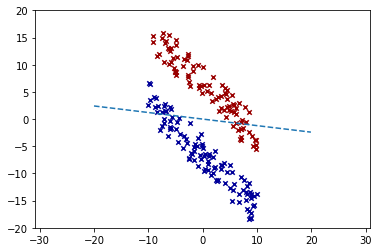

In [95]:
plot_data(lr_classifiers[0], small_data_X, small_data_Y)

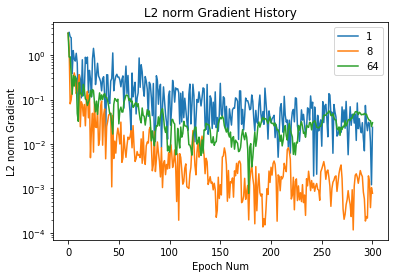

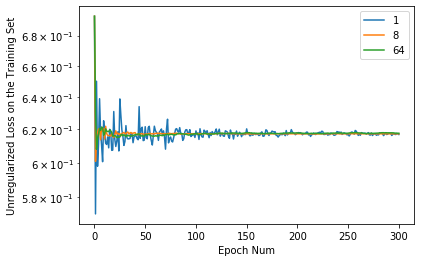

In [96]:
# Plot L2 norm gradient history.
plt.figure()
plt.yscale('log')

plt.ylabel('L2 norm Gradient')
plt.xlabel('Epoch Num')
plt.title('L2 norm Gradient History')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in range(len(lr_classifier.l2_norm_gradient_history_))], lr_classifier.l2_norm_gradient_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

# Plot training histories.
plt.figure()
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Training Set')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in range(len(lr_classifier.training_unregularized_loss_history_))], lr_classifier.training_unregularized_loss_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

# Checkpoint: Pegasos for Regularized Hinge Loss SVM
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the second checkpoint.

In [97]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(small_data_X.shape[1])
pegasos(svm_classifier_obj, small_data_X, small_data_Y, None, None, regularization=100, num_epochs=300, mini_batch_size=20)
print(svm_classifier_obj.weight_)

Epoch  10  is complete...
Epoch  20  is complete...
Epoch  30  is complete...
Epoch  40  is complete...
Epoch  50  is complete...
Epoch  60  is complete...
Epoch  70  is complete...
Epoch  80  is complete...
Epoch  90  is complete...
Epoch  100  is complete...
Epoch  110  is complete...
Epoch  120  is complete...
Epoch  130  is complete...
Epoch  140  is complete...
Epoch  150  is complete...
Epoch  160  is complete...
Epoch  170  is complete...
Epoch  180  is complete...
Epoch  190  is complete...
Epoch  200  is complete...
Epoch  210  is complete...
Epoch  220  is complete...
Epoch  230  is complete...
Epoch  240  is complete...
Epoch  250  is complete...
Epoch  260  is complete...
Epoch  270  is complete...
Epoch  280  is complete...
Epoch  290  is complete...
Epoch  300  is complete...
[-0.00437457 -0.05891292]


# Pegasos on Criteo CTR Prediction Data
Once you are here, now you are ready to run on a real data. First let us try the regularized logistic regression. Use $\lambda = 0.1$, and $T = 100$.

In [98]:
# Train Pegasos logistic regression classifier.
lr_classifier = logistic_regression_classifier(training_data_X.shape[1])
print(type(training_data_X))
print(training_data_X.shape)
print(type(training_data_Y))
print(training_data_Y.shape)
pegasos(lr_classifier, training_data_X, training_data_Y, validation_data_X, \
        validation_data_Y, regularization=0.1, num_epochs=100, mini_batch_size=64)
print(lr_classifier.weight_)

<class 'numpy.ndarray'>
(16000, 24)
<class 'numpy.ndarray'>
(16000,)
Epoch  10  is complete...
Epoch  20  is complete...
Epoch  30  is complete...
Epoch  40  is complete...
Epoch  50  is complete...
Epoch  60  is complete...
Epoch  70  is complete...
Epoch  80  is complete...
Epoch  90  is complete...
Epoch  100  is complete...
[-5.45018792e-04 -3.42917512e-02 -3.27959123e-01 -1.58289939e-03
 -1.06311181e-04 -4.29563990e-02 -1.64302138e-03 -3.42917512e-02
 -3.31836374e-01 -3.46306997e-02 -8.32569930e-03 -1.58590920e-02
  1.41968004e-02 -4.01470675e-01 -2.78288444e-04 -5.75676089e-03
  8.34918107e-05 -1.58590920e-02 -4.10411461e-01 -5.75676089e-03
  2.83453170e-02 -2.78288444e-04 -5.20773009e-03  8.34918107e-05]


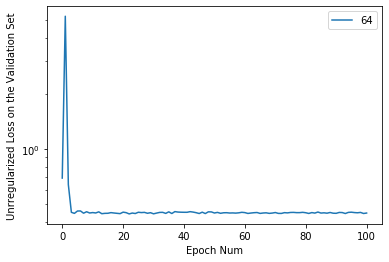

In [99]:
# Plot validation histories.
plt.figure()
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot([epoch for epoch in range(len(lr_classifier.validation_unregularized_loss_history_))], lr_classifier.validation_unregularized_loss_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

Next, run on the regularized hinge loss SVM. Again, use $\lambda = 0.1$, and $T = 100$.

In [100]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(training_data_X.shape[1])
pegasos(svm_classifier_obj, training_data_X, training_data_Y, validation_data_X, validation_data_Y, regularization=0.1, num_epochs=100, mini_batch_size=64)
print(svm_classifier_obj.weight_)

Epoch  10  is complete...
Epoch  20  is complete...
Epoch  30  is complete...
Epoch  40  is complete...
Epoch  50  is complete...
Epoch  60  is complete...
Epoch  70  is complete...
Epoch  80  is complete...
Epoch  90  is complete...
Epoch  100  is complete...
[-2.61786512e-03 -1.69519069e-01 -2.32989883e-01 -3.52035491e-03
 -1.54984157e-03 -1.30416873e-01 -1.53312537e-02 -1.69519069e-01
 -2.56009198e-01 -1.07924913e-01 -2.24919593e-02 -5.44713527e-02
 -1.49906914e-01 -3.38186153e-01 -6.84340727e-04 -1.28219424e-02
  1.25563196e-04 -5.44713527e-02 -4.01931735e-01 -1.28219424e-02
 -6.60682670e-02 -6.84340727e-04 -2.00930648e-02  1.25563196e-04]


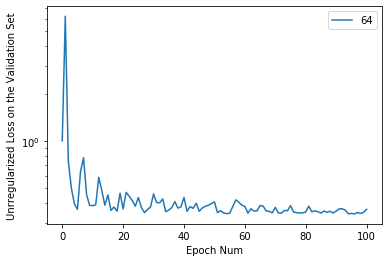

In [101]:
# Plot validation histories.
plt.figure()
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot([epoch for epoch in range(len(svm_classifier_obj.validation_unregularized_loss_history_))], svm_classifier_obj.validation_unregularized_loss_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

For both of classifiers, try to find a setting of parameters $\lambda$ and $| M |$ that gives the best accuracy on the validation set.

For the few brave students, try to optimize your code to work on sparse data.